# Starting the Grote - Hynes calculation from scratch
We are going to go step by step in the calculation, without relying much in previous pieces of code.

In [52]:
%load_ext autoreload
%matplotlib inline
import math
import copy
import inspect
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})
colors = ['orange', 'red', 'blue', 'cyan']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Fits to autocorrelation functions
We start with the lowest viscosity ACF which we used in the paper. 

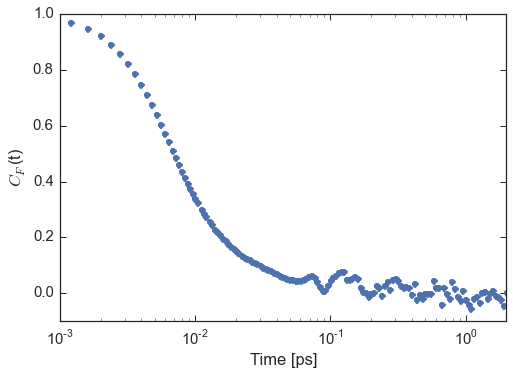

In [53]:
path_facf = "data/LJ_tip3pTRUE_freeze_n"
visc = 0
file_facf = path_facf + "%g_force_acf_select.dat"%visc
data = np.array([[float(x.split()[0]), float(x.split()[1]), \
                  float(x.split()[2])] for x in open(file_facf).readlines()])
time = data[:,0]
acf = data[:,2]
fig, ax = plt.subplots()
ax.plot(time, acf,'o')
ax.set_xscale('log')
ax.set_xlabel('Time [ps]')
ax.set_ylim(-0.1,1)
ax.set_xlim(1e-3,2)
_ = ax.set_ylabel(r'$C_F$(t)')

Next we include a class for fitting the data. It includes different types of methods for creating the parameters we need, carrying out the fitting, obtaining the goodness of the fit, scaling the function forward or backward in time, integrating the resulting fit, and retrieving its Laplace transform.

In [54]:
class Fit():
    def __init__(self, formula, x, y, p0=None):
        self.formula = formula
        print " fitting data to %s"%formula.__name__
        self.create_params(p0)
        print "     initial parameters:",self.p0
        self.fit_function(x,y)
        print "     fitted parameters:",self.popt
        self.calc_r2(y,self.formula(x,*self.popt))
        print "     R**2: %g "%self.r2

    def __call__(self,t):
        return self.formula(t,*self.popt)

    def create_params(self,p0=None):
        """ create parameters """
        # define number of parameters
        self.nparams = len(inspect.getargspec(self.formula)[0]) - 1
        print "      number of parameters: %g"%self.nparams
        # check for user defined initial parameters
        if not p0:
            self.p0 = np.random.random(self.nparams)
        else:
            if len(p0) != self.nparams:
                print " Wrong number of initial parameters",len(p0)
                print "          %g required"%self.nparams 
                sys.exit(1)
            self.p0 = p0

    def fit_function(self,x,y,p0=None):
        """ fit the data to the chosen functional form """
        popt, pcov = curve_fit(self.formula, x, y, p0=self.p0, maxfev = self.nparams*1000000)
        self.popt = popt
        self.pcov = pcov

    def calc_r2(self,y,ycalc):
        """ define goodness of fit metric """
        sse = np.sum((y-ycalc)**2)
        sst = np.sum((y-np.mean(y))**2)
        self.r2 = 1 - (sse/sst)*(len(y)-1)/(len(y)-self.nparams)
   
    def integrate(self):
        #x = np.logspace(-9,4,1e6)
        xx = np.linspace(0, 1e2, 1e6)
        #return np.trapz(self.formula(x, *self.popt),x)
        return np.trapz(self.formula(xx, *self.popt),xx)
    
    def laplace(self,lmbd):
        """ calculate laplace transform """
        p = self.popt
        if self.formula.__name__ == "exp1":
            return laplace_exp1(lmbd,p)
        elif self.formula.__name__ == "expsq":
            return laplace_expsq(lmbd,p)
        elif self.formula.__name__ == "exp1_expsq":
            c0 = p[0]/(1. + p[0]); c1 = 1 - c0
            return c0*laplace_exp1(lmbd,p[1]) + c1*laplace_expsq(lmbd,p[2])
        elif self.formula.__name__ == "exp2_expsq":
            norm = 1. + p[0] + p[1]; c0 = p[0]/norm; c1 = p[1]/norm; c2 = 1 - c0 - c1
            return c0*laplace_exp1(lmbd,p[2]) + c1*laplace_exp1(lmbd,p[3]) \
                    + c2*laplace_expsq(lmbd,p[4])
        
    def scale(self, scfactor):
        """ rescale time """
        np = self.nparams
        if self.formula.__name__ == "exp1":
            self.popt = self.popt*scfactor
        elif self.formula.__name__ == "expsq":
            self.popt = self.popt*scfactor
        elif self.formula.__name__ == "exp1_expsq":
            self.popt[1] = self.popt[1]*scfactor
            self.popt[2] = self.popt[2]*scfactor**2
        elif self.formula.__name__ == "exp2_expsq":
            self.popt[2] = self.popt[2]*scfactor
            self.popt[3] = self.popt[3]*scfactor
            self.popt[4] = self.popt[4]*scfactor**2

#### Exponential fit
We start with a naive guess for our function: a single exponential function of the form $y=\exp(-a*x), which is defined below:

In [55]:
def exp1(x,a):
    return np.exp(-a*x)

def laplace_exp1(s,a):
    return 1./(s+a)

Now we carry out the actual fitting exercise

In [56]:
exp1_fit = Fit(exp1,time,acf)

 fitting data to exp1
      number of parameters: 1
     initial parameters: [ 0.68928155]
     fitted parameters: [ 95.10830292]
     R**2: 0.978404 


The fit is clearly not very good but it sets some good ground for further work. We see that it does not recover the initial, sharper curvature in the data nor the slower decay at long times.

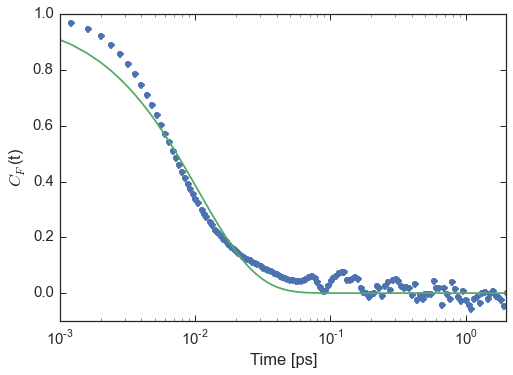

In [57]:
time = data[:,0]
acf = data[:,2]
fig, ax = plt.subplots()
ax.plot(time, acf,'o', time,exp1_fit(time))
ax.set_xscale('log')
ax.set_xlabel('Time [ps]')
ax.set_ylim(-0.1,1)
ax.set_xlim(1e-3,2)
_ = ax.set_ylabel(r'$C_F$(t)')

OK, so let's now test the integration of the friction kernel issue, without including $\beta m^{-1}<F^2>$.

In [58]:
print "Integral : %g"%(exp1_fit.integrate())
print "Laplace : %g"%(exp1_fit.laplace(0))

Integral : 0.0105144
Laplace : 0.0105143


####Squared exponential fit

 fitting data to expsq
      number of parameters: 1
     initial parameters: [ 0.22943839]
     fitted parameters: [ 11108.36223665]
     R**2: 0.94282 


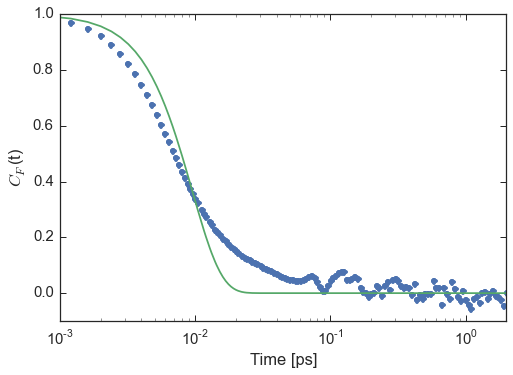

In [59]:
from scipy.special import erfc

def expsq(x,a):
    return np.exp(-a*x**2)

def laplace_expsq(s,a):
    return math.sqrt(math.pi)/(2.*math.sqrt(a))*np.exp((s**2)/(4.*a))*erfc(s/(2.*math.sqrt(a)))

expsq_fit = Fit(expsq,time,acf)

time = data[:,0]
acf = data[:,2]
fig, ax = plt.subplots()
ax.plot(time, acf,'o', time,expsq_fit(time))
ax.set_xscale('log')
ax.set_xlabel('Time [ps]')
ax.set_ylim(-0.1,1)
ax.set_xlim(1e-3,2)
_ = ax.set_ylabel(r'$C_F$(t)')

Clearly the fit is worse here than before but still it will allow for us for further testing.

In [60]:
print "Integral : %g"%(expsq_fit.integrate())
print "Laplace : %g"%(expsq_fit.laplace(0))

Integral : 0.00840853
Laplace : 0.00840853


#### Sum of squared exponential and exponential fits

 fitting data to exp1_expsq
      number of parameters: 3
     initial parameters: [0.1, array([ 95.10830292]), array([ 11108.36223665])]
     fitted parameters: [  5.98300500e-01   4.09590236e+01   2.13790444e+04]
     R**2: 0.991582 


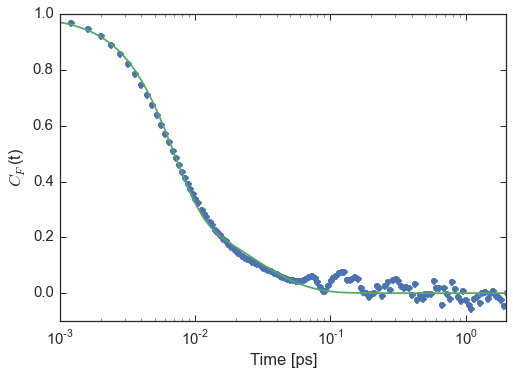

In [61]:
def exp1_expsq(x, a, b, c):
    p0 = a/(1.+ a)
    p1 = 1. - p0
    return p0*np.exp(-b*x) + p1*np.exp(-c*x**2)

exp1_expsq_fit = Fit(exp1_expsq,time,acf, p0=[0.1, exp1_fit.popt, expsq_fit.popt])

time = data[:,0]
acf = data[:,2]
fig, ax = plt.subplots()
ax.plot(time, acf,'o', time, exp1_expsq_fit(time))
ax.set_xscale('log')
ax.set_xlabel('Time [ps]')
ax.set_ylim(-0.1,1)
ax.set_xlim(1e-3,2)
_ = ax.set_ylabel(r'$C_F$(t)')

In [62]:
print "Integral : %g"%(exp1_expsq_fit.integrate())
print "Laplace : %g"%(exp1_expsq_fit.laplace(0))

Integral : 0.0129315
Laplace : 0.0129315


So certainly this function that reproduces the data very nicely we recover the correct integral and Laplace transform. So everything is good.

####Sum of two exponentials and a squared exponential

 fitting data to exp2_expsq
      number of parameters: 5
     initial parameters: [0.5983004997730027, 0.0, 0.0, 40.959023617217476, 21379.044376181999]
     fitted parameters: [  1.08561875e-01   8.64588069e-01   3.92487633e+00   7.16652559e+01
   2.05111706e+04]
     R**2: 0.995182 


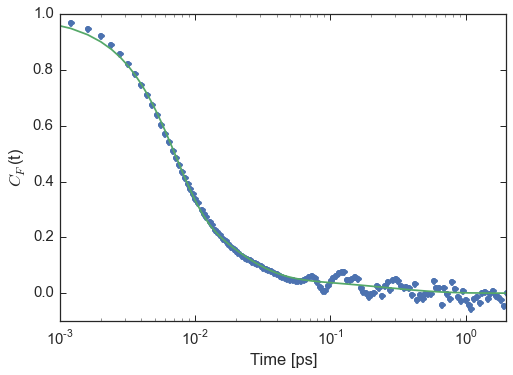

In [63]:
def exp2_expsq(x, a, b, c, d, e):
    p0 = a/(1.+ a + b)
    p1 = b/(1.+ a + b)
    p2 = 1 - p0 - p1
    return p0*np.exp(-c*x) + p1*np.exp(-d*x) + p2*np.exp(-e*x**2)

exp2_expsq_fit = Fit(exp2_expsq,time,acf, p0=[exp1_expsq_fit.popt[0],0.,0.,\
         exp1_expsq_fit.popt[1],exp1_expsq_fit.popt[2]])
time = data[:,0]
acf = data[:,2]
fig, ax = plt.subplots()
ax.plot(time, acf,'o', time, exp2_expsq_fit(time))
ax.set_xscale('log')
ax.set_xlabel('Time [ps]')
ax.set_ylim(-0.1,1)
ax.set_xlim(1e-3,2)
_ = ax.set_ylabel(r'$C_F$(t)')

In [64]:
print "Integral : %g"%(exp1_expsq_fit.integrate())
print "Laplace : %g"%(exp1_expsq_fit.laplace(0))

Integral : 0.0129315
Laplace : 0.0129315


###Scaling the fitted functions with the viscosity scaling
The next step is to reproduce the correlation functions at all viscosity values using the scaling the times by a factor of $\eta_\mathrm{Ref}/\eta_\mathrm{Target}$. We do this exercise both for the exponential fit and for the more complex fit that recovers the right functional form.

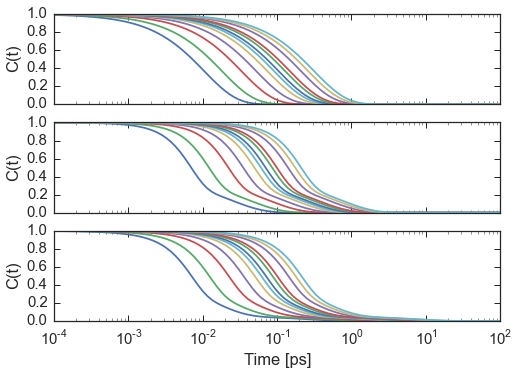

In [65]:
viscosities = [0.1, 0.173205, 0.316228, 0.5, 0.707107, 0.866025,\
           1, 1.22474, 1.41421, 2, 2.5, 3]
eta_ref = viscosities[0]
time = np.logspace(-4,2,100)
fig, ax = plt.subplots(3,1, sharex=True)
for eta in viscosities:
    scaledfit = copy.deepcopy(exp1_fit)
    scaledfit.scale(eta_ref/eta)
    ax[0].plot(time,scaledfit(time))
    ax[0].set_xscale('log')
for eta in viscosities:
    scaledfit = copy.deepcopy(exp1_expsq_fit)
    scaledfit.scale(eta_ref/eta)
    ax[1].plot(time,scaledfit(time))
    ax[1].set_xscale('log')
for eta in viscosities:
    scaledfit = copy.deepcopy(exp2_expsq_fit)
    scaledfit.scale(eta_ref/eta)
    ax[2].plot(time,scaledfit(time))
    ax[2].set_xscale('log')
ax[2].set_xlabel('Time [ps]')
ax[0].set_ylabel('C(t)')
ax[1].set_ylabel('C(t)')
_ = ax[2].set_ylabel('C(t)')

The question of course is whether this agrees with the true autocorrelation functions obtained from MD.

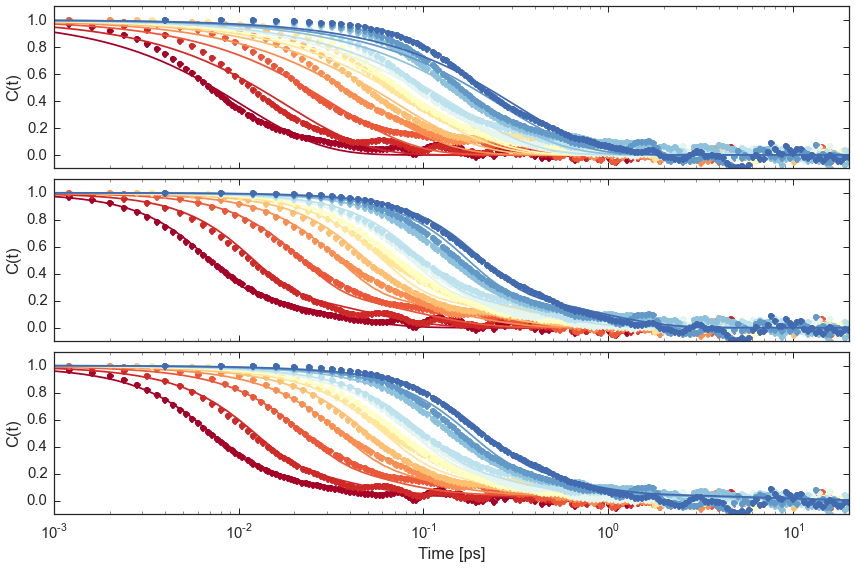

In [66]:
# read acf
facf = []
path_facf = "data/LJ_tip3pTRUE_freeze_n"
lvisc = len(viscosities)
for i in range(lvisc):
    file_facf = path_facf + "%g_force_acf_select.dat"%i
    data = np.array([[float(x.split()[0]), float(x.split()[1]), \
            float(x.split()[2])] for x in open(file_facf).readlines()])
    facf.append(data)

f2mean = np.mean([x[0,1] for x in facf])
#f2mean = facf[0][0,1] # mean squared force

k = 0
tsim = np.logspace(-4,2,100)
fig, ax = plt.subplots(3,1, figsize=(12,8), sharex=True)
for eta in viscosities:
    time = facf[k][:,0] # in ps
    acf = facf[k][:,2]
    col = float(k)/lvisc
    ax[0].plot(time, acf, 'o', color=plt.cm.RdYlBu(col))
    ax[1].plot(time, acf, 'o', color=plt.cm.RdYlBu(col))
    ax[2].plot(time, acf, 'o', color=plt.cm.RdYlBu(col))
    scaledfit = copy.deepcopy(exp1_fit)
    scaledfit.scale(eta_ref/eta)
    ax[0].plot(tsim, scaledfit(tsim), color=plt.cm.RdYlBu(col))
    scaledfit = copy.deepcopy(exp1_expsq_fit)
    scaledfit.scale(eta_ref/eta)
    ax[1].plot(tsim, scaledfit(tsim), color=plt.cm.RdYlBu(col))
    scaledfit = copy.deepcopy(exp2_expsq_fit)
    scaledfit.scale(eta_ref/eta)
    ax[2].plot(tsim, scaledfit(tsim), color=plt.cm.RdYlBu(col))

    k +=1
ax[0].set_xlim(1e-3, 20)
ax[0].set_ylim(0, 1)
ax[0].set_ylim(-0.1, 1.1)
ax[1].set_ylim(-0.1, 1.1)
ax[2].set_ylim(-0.1, 1.1)
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[2].set_xlabel('Time [ps]')
ax[0].set_ylabel('C(t)')
ax[1].set_ylabel('C(t)')
ax[2].set_ylabel('C(t)')
_ = plt.tight_layout()

Clearly, the procedure is fairly efficient in producing the desired time decays. The lack of fidelity on the top plot is only due to the fact that a single exponential does not reproduce the MD data well. On the contrary the sum of single exponential and squared exponential is very good. Now, do the Laplace transforms of these functions result in the desired values?

In [67]:
print "  Single Exponential Fit"
print "--------------------------"
print "  Laplace   Integral"
for eta in viscosities:
    scaledfit = copy.deepcopy(exp1_fit)
    scaledfit.scale(eta_ref/eta)
    print " %10.2e %10.2e"%(scaledfit.laplace(0)[0], scaledfit.integrate())
print "\n  Exp + Exp^2 Fit"
print "--------------------------"
print "  Laplace   Integral"
for eta in viscosities:
    scaledfit = copy.deepcopy(exp1_expsq_fit)
    scaledfit.scale(eta_ref/eta)
    print " %10.2e %10.2e"%(scaledfit.laplace(0), scaledfit.integrate())
print "\n  Exp  + Exp + Exp^2 Fit"
print "--------------------------"
print "  Laplace   Integral"
for eta in viscosities:
    scaledfit = copy.deepcopy(exp2_expsq_fit)
    scaledfit.scale(eta_ref/eta)
    print " %10.2e %10.2e"%(scaledfit.laplace(0), scaledfit.integrate())

  Single Exponential Fit
--------------------------
  Laplace   Integral
   1.05e-02   1.05e-02
   1.82e-02   1.82e-02
   3.32e-02   3.32e-02
   5.26e-02   5.26e-02
   7.43e-02   7.43e-02
   9.11e-02   9.11e-02
   1.05e-01   1.05e-01
   1.29e-01   1.29e-01
   1.49e-01   1.49e-01
   2.10e-01   2.10e-01
   2.63e-01   2.63e-01
   3.15e-01   3.15e-01

  Exp + Exp^2 Fit
--------------------------
  Laplace   Integral
   1.29e-02   1.29e-02
   2.24e-02   2.24e-02
   4.09e-02   4.09e-02
   6.47e-02   6.47e-02
   9.14e-02   9.14e-02
   1.12e-01   1.12e-01
   1.29e-01   1.29e-01
   1.58e-01   1.58e-01
   1.83e-01   1.83e-01
   2.59e-01   2.59e-01
   3.23e-01   3.23e-01
   3.88e-01   3.88e-01

  Exp  + Exp + Exp^2 Fit
--------------------------
  Laplace   Integral
   2.33e-02   2.33e-02
   4.03e-02   4.03e-02
   7.36e-02   7.36e-02
   1.16e-01   1.16e-01
   1.65e-01   1.65e-01
   2.02e-01   2.02e-01
   2.33e-01   2.33e-01
   2.85e-01   2.85e-01
   3.29e-01   3.29e-01
   4.65e-01   4.65e-01
   5

We can also plot the friction kernels at different viscosity values.

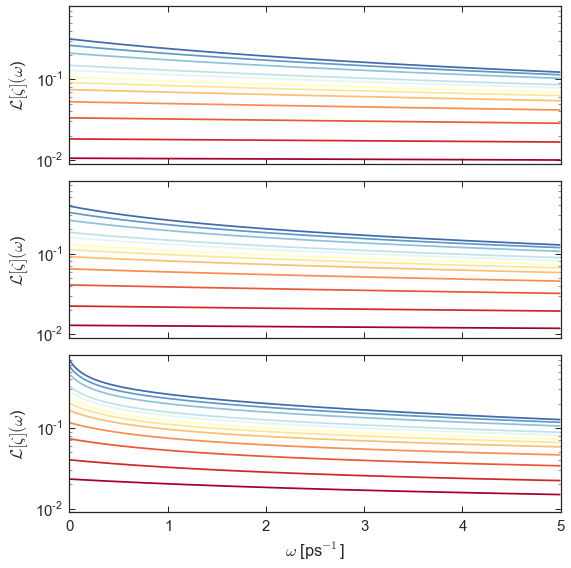

In [68]:
k = 0
fig, ax = plt.subplots(3,1, figsize=(8,8), sharex=True)
omega = np.arange(0,5,0.01)
for eta in viscosities:
    col = float(k)/lvisc
    scaledfit = copy.deepcopy(exp1_fit)
    scaledfit.scale(eta_ref/eta)
    ax[0].plot(omega, scaledfit.laplace(omega), color=plt.cm.RdYlBu(col))
    scaledfit = copy.deepcopy(exp1_expsq_fit)
    scaledfit.scale(eta_ref/eta)
    ax[1].plot(omega, scaledfit.laplace(omega), color=plt.cm.RdYlBu(col))
    scaledfit = copy.deepcopy(exp2_expsq_fit)
    scaledfit.scale(eta_ref/eta)
    ax[2].plot(omega, scaledfit.laplace(omega), color=plt.cm.RdYlBu(col))
    k+=1
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[0].set_ylim(9e-3,0.8)
ax[1].set_ylim(9e-3,0.8)
ax[2].set_ylim(9e-3,0.8)
ax[2].set_xlabel('$\omega$ [ps$^{-1}$]')
ax[0].set_ylabel('$\mathcal{L}[\zeta](\omega$)')
ax[1].set_ylabel('$\mathcal{L}[\zeta](\omega$)')
ax[2].set_ylabel('$\mathcal{L}[\zeta](\omega$)')
_ = plt.tight_layout()

###TST, Kramers and Grote-Hynes rate estimates
Now that we are a bit more confident on the workings of the friction kernel, we can just add the bits and pieces that are required to do the Kramers rate estimate. First we do some definitions, corresponding to transition state theory.

####Transition state theory
Transition state theory (TST) is neccesarily an upper bound to the true rate, since every time that the particle reaches the barrier it will cross it. The TST rate can be calculated as

$k^{TST}=(\omega_b/2\pi)\exp(-\beta\Delta G_{b\ddagger})$

where $\omega_b$ is the frequency at the bottom of the reactant well and $\Delta G_{b\ddagger}$ is the energy barrier (in this case, $\Delta G_{b\ddagger}=2V_0$).

Approximating the potential locally as a parabola of the form $V_{\mathrm{max}} - 1/2 k(x-x_0)^2$ we obtain the spring constant $k = V''$. The second derivative of our potential, 

$V(x)=-V_0(2\pi n/l)^2\cos(2\pi x/l)$

at the barrier top has a value of $V''(0)=-V_0(2\pi n/l)^2$. Hence we 
can calculate the barrier frequency, $\omega_\ddagger=\sqrt{k/m}$. Substituting we find that 

$	\omega_\ddagger = (2\pi n/l)\sqrt{V_0/m}$

using the particle mass $m$=12.01 g/mol. The resulting values are calculated below. 
def frequency(n, V0, lbox, m):

In [69]:
def frequency(n, V0, lbox, m):
    """ 
    Calculates frequency based on parameters.
    
    Parameters
    ----------
    V0 : float
        Potential.
    
    n : int
        Number of periods.
        
    lbox : float
        Box length in nm.
        
    Returns
    -------
    const : float
        Force constant.
        
    omega : float
        Frequency of the well.
        
    """
    const = V0*(2.*math.pi*n/lbox)**2
    omega = math.sqrt(const/m*1.e-3)
    return const, omega

# define parameters from the simulations
mass = 12e-3 # in kg/mol
beta = 1./(8.314e-3*300) # in (kJ/mol)^-1
lbox = 3.2 # in nm
barrier = 10 
V0 = barrier/2. # amplitude in kJ/mol

# calculate barrier dependent term
tst_exp = 1./(2.*math.pi)*math.exp(-beta*2.*V0)
periods = [2, 4, 6, 8]

# calculate barrier frequency
print " Barrier frequencies and transition state theory rates"
print "  n  k [kJ/(mol*nm**2)] omega [ps-1] ktst [ps-1]"
ktst = []
omega = []
for prd in periods:
    # calculate frequency of the potential
    k, om = frequency(prd, V0, lbox, mass)
    omega.append(om)
    ktst.append(om*tst_exp)
    print " %2i  %12.4f   %12.4f   %12.4e "%(prd, k, om, ktst[-1])

 Barrier frequencies and transition state theory rates
  n  k [kJ/(mol*nm**2)] omega [ps-1] ktst [ps-1]
  2       77.1063         2.5349     7.3208e-03 
  4      308.4251         5.0697     1.4642e-02 
  6      693.9566         7.6046     2.1962e-02 
  8     1233.7006        10.1394     2.9283e-02 


####Kramers theory
Next we calculate the Kramers rate using the high and intermediate friction rate expressions. In the high friction regime the rate expression is

$k_{\mathrm{K}}=
		(\omega_b\omega_\ddagger/2\pi\gamma)\exp(-\beta\Delta G)$
        
where $\gamma$ is the friction coefficient and $\omega_b$ is the frequency at the bottom of the well (which in our case is conveniently equal to that at the top of the barrier, $\omega_b=\omega_\ddagger$). At intermediate friction we must use 

$k_{\mathrm{K}}=
	\big([(\gamma/4)^2+\omega_\ddagger^2]^{1/2}-\gamma/2\big)/\omega_\ddagger
    (\omega_b/2\pi)\exp(-\beta\Delta G_\ddagger).$

All of the terms in Kramers rate expressions can be calculated from the simulation data itself and are included in the following function.

In [70]:
def kramers(omega, gamma, ktst, option=None):
    """ Calculates Kramers rates.
    
    Parameters:
    ----------
    omega : float
        Barrier / well frequency
        
    gamma : float
        Friction coefficient.
        
    ktst : float
        Transition state theory rate.

    Returns:
    --------
    float
    
    """
    if option == "strong":
        return omega/gamma*ktst
    elif option == "inter":
        return (math.sqrt(1. + (gamma/(2*omega))**2) - gamma/(2*omega))*ktst

We obtain the friction coefficient as

$\gamma = \zeta_0/m = m^{-1}\int_0^\infty\zeta(t)dt$

where we are using the memory friction $\zeta(t)$, defined as 

$\zeta(t) = \beta <F_x(\tau)F_x(\tau+t)>_\tau$

In brackets we show the autocorrelation function of the x component of the solvent forces on the particle (i.e. the contribution corresponding to the reaction coordinate for the barrier crossing problem we are studying). In the above calculations on the autocorrelation function we have already learned how to evaluate the integral of the friction kernel, either by direct integration or by obtention of the Laplace transform at $\omega=0$.

In [71]:
lprd = len(periods)
scaling = np.logspace(-3, 1, 50)
lsc = len(scaling)
kKZ = np.zeros((lprd, lsc), float)
kKZinter = np.zeros((lprd, lsc), float)
l = 0
for sc in scaling:
    scaledfit = copy.deepcopy(exp2_expsq_fit)
    scaledfit.scale(eta_ref/sc)
    gamma_zeta = beta/mass*f2mean*scaledfit.laplace(0)*1e-3
    #print scaledfit.integrate(), scaledfit.laplace(0)
    for n in range(lprd):
        kKZ[n,l] = kramers(omega[n], gamma_zeta, ktst[n], option="strong")
        kKZinter[n,l] = kramers(omega[n], gamma_zeta, ktst[n], option="inter")
    l +=1

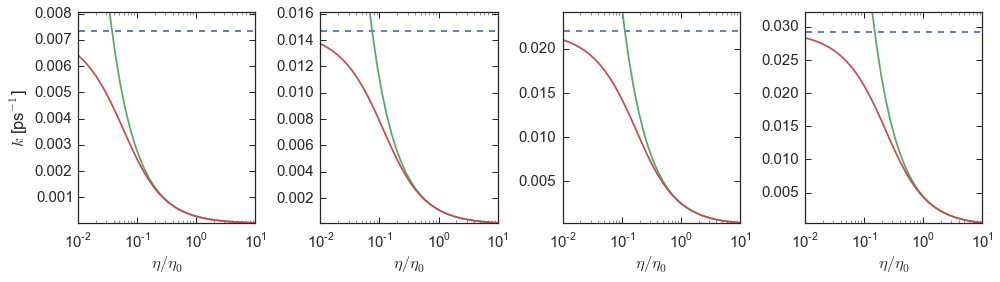

In [72]:
fig, ax = plt.subplots(1,4, figsize=(14,4))
for i in range(lprd):
    ax[i].plot(scaling, ktst[i]*np.ones(lsc),'--')
    ax[i].plot(scaling, kKZ[i,:], scaling, kKZinter[i,:])
    ax[i].set_xlim(1e-2,10)
    ax[i].set_ylim(np.min(kKZ[i,:]),1.1*ktst[i])
    #ax[i].xaxis.set_ticks(range(0,4,1))
    ax[i].set_xlabel(r'$\eta/\eta_0$')
    ax[i].set_xscale('log')
ax[0].set_ylabel(r'$k$ [ps$^{-1}$]')
plt.tight_layout()

### Grote-Hynes calculation
We finish up by doing the Grote-Hynes rate theory calculation. For this we need the fitted function, whose Laplace transform is used to obtain the reactive frequency. The Grote-Hynes rate is calculated as 
\begin{equation}
	k =\kappa k^{TST}=\lambda/\omega_\ddagger k^{TST}
\end{equation}
where $\kappa$ is the dynamical transmission coefficient, $k^{TST}$ is the transition state theory rate, $\lambda$ is the reactive frequency and $\omega_\ddagger$ is the fequency of the parabolic activation barrier. When collisions are unimportant, we have $\omega_\ddagger=\lambda$ and transition state theory rate applies. The reactive frequency $\lambda$ is obtained using the self-consistent  relation 
\begin{equation}
\lambda=[\lambda+\hat\zeta(\lambda)]^{-1}\omega_b^2
\end{equation}
where we are using the Laplace transform of the frequency dependent friction, calculated above
\begin{equation}
\hat\zeta(\lambda)=\int^\infty_0 dt [e^{-\lambda t} \zeta(t)]
\end{equation}


In [73]:
kGH = np.zeros((lprd, lsc), float)
for n in range(lprd):
    # open file for output
    prd = periods[n]
    # self consistently calculate lambda
    l = 0
    for sc in scaling:
        scaledfit = copy.deepcopy(exp2_expsq_fit)
        scaledfit.scale(eta_ref/sc)
        lmbd = omega[n]
        diff = 1e20
        while (abs(diff/lmbd)>1e-4):
            Lzeta = beta/mass*f2mean*scaledfit.laplace(lmbd)*1e-3 # ps-1
            lmbd_new = (omega[n]**2)/(lmbd + Lzeta) # Eq 4.27 in Grote & Hynes, JCP 1981
            diff = abs(lmbd - lmbd_new)
            lmbd = lmbd_new
            # Grote-Hynes
        kGH[n,l] = lmbd/omega[n]*ktst[n]
        l +=1

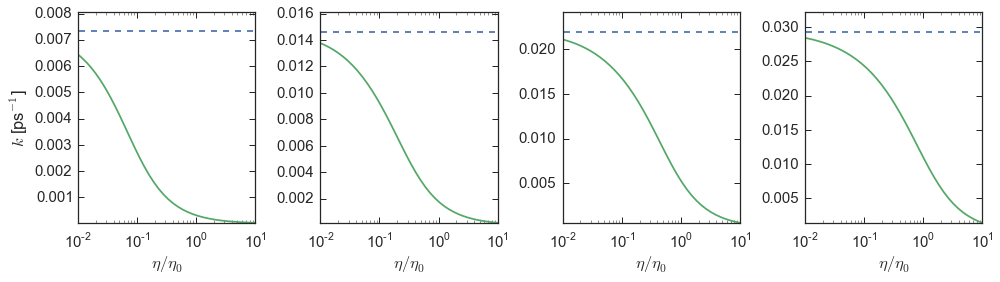

In [74]:
fig, ax = plt.subplots(1,4, figsize=(14,4))
for i in range(lprd):
    ax[i].plot(scaling, ktst[i]*np.ones(lsc),'--')
    ax[i].plot(scaling, kGH[i,:],'-')
    #ax[i].set_xlim(0,3.2)
    ax[i].set_ylim(np.min(kGH[i,:]),1.1*ktst[i])
    ax[i].xaxis.set_ticks(range(0,4,1))
    ax[i].set_xlim(1e-2,10)
    ax[i].set_xlabel(r'$\eta/\eta_0$')
    ax[i].set_xscale('log')
#    ax[i].set_yscale('log')
ax[0].set_ylabel(r'$k$ [ps$^{-1}$]')
plt.tight_layout()

## Comparison with simulation results

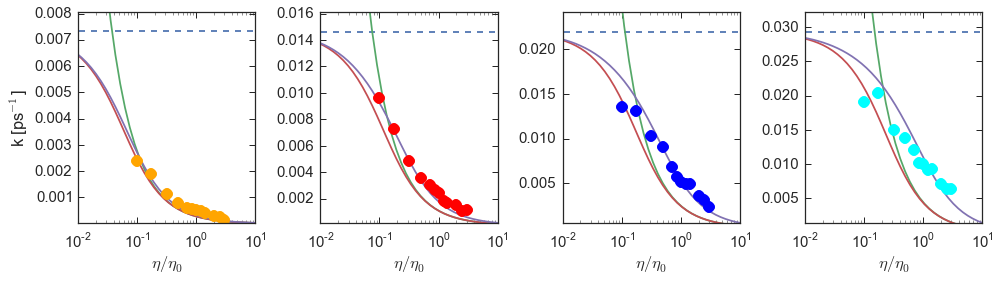

In [75]:
fig, ax = plt.subplots(1,4, figsize=(14,4))
for i in range(lprd):
    ax[i].plot(scaling, ktst[i]*np.ones(lsc),'--')
    ax[i].plot(scaling, kKZ[i,:])
    ax[i].plot(scaling, kKZinter[i,:])
    ax[i].plot(scaling, kGH[i,:])
    ax[i].set_ylim(np.min(kGH[i,:]),1.1*ktst[i])
    ax[i].set_xlim(1e-2,10)
    ax[i].set_xlabel(r'$\eta/\eta_0$')
    ax[i].set_xscale('log')
#   ax[i].set_yscale('log')
    filename = "data/tau_vs_visc_bumpy%g.dat"%periods[i]
    data = [(float(x.split()[0]),float(x.split()[1]),float(x.split()[2])) \
            for x in open(filename).readlines()]
    data = np.array(data)
    ax[i].plot(data[:,0],1./(4*data[:,1]),'o', color=colors[i],markersize=12)
    ax[i].set_xlabel(r'$\eta/\eta_0$')
ax[0].set_ylabel(r'k [ps$^{-1}$]')
_  = plt.tight_layout()

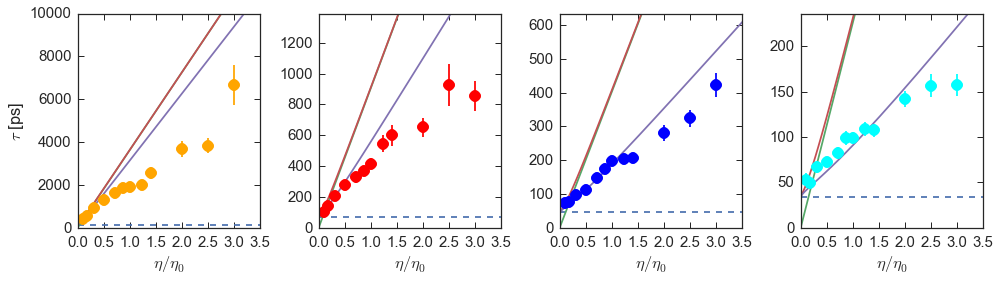

In [76]:
fig, ax = plt.subplots(1,4, figsize=(14,4))
for i in range(lprd):
    ax[i].plot(scaling, 1./ktst[i]*np.ones(lsc),'--')
    ax[i].plot(scaling, 1./kKZ[i,:])
    ax[i].plot(scaling, 1./kKZinter[i,:])
    ax[i].plot(scaling, 1./kGH[i,:])
    ax[i].set_xlim(0,3.5)
    ax[i].set_xlabel(r'$\eta/\eta_0$')
#    ax[i].set_xscale('log')
#   ax[i].set_yscale('log')
    filename = "data/tau_vs_visc_bumpy%g.dat"%periods[i]
    data = [(float(x.split()[0]),float(x.split()[1]),float(x.split()[2])) \
            for x in open(filename).readlines()]
    data = np.array(data)
    ax[i].errorbar(data[:,0],4*data[:,1],yerr=4*data[:,2],fmt='o', color=colors[i],markersize=12)
    ax[i].set_ylim(0,4*np.max(data[:,1])*1.5)
    ax[i].set_xlabel(r'$\eta/\eta_0$')
ax[0].set_ylabel(r'$\tau$ [ps]')
_  = plt.tight_layout()